Importing modules

In [1]:
import numpy as np
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from sklearn import decomposition
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score

Dataset link: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# Data preprocessing

Filling in the names of image classes

In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain',
               'sea', 'street']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

Function for uploading images

In [3]:
def load_data():
  datasets = ['seg_train/seg_train', 
              'seg_test/seg_test']
  output = []

  for dataset in datasets:
    images = []
    labels = []

    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      label = class_names_label[folder]

      for file in tqdm(os.listdir(os.path.join(dataset, folder))):
        img_path = os.path.join(os.path.join(dataset, folder), file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        images.append(image)
        labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    output.append((images, labels))

  return output

Split the images into a training set and a test set

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train/seg_train


100%|██████████| 2382/2382 [00:15<00:00, 156.11it/s]


Loading seg_test/seg_test


100%|██████████| 501/501 [00:03<00:00, 138.39it/s]


Shuffling the sets

In [5]:
train_images, train_labels = shuffle(train_images, train_labels,
                                     random_state=25)

Output the information about the sets

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of examples in the training set: {}".format(n_train))
print("Number of examples in the test set: {}".format(n_test))
print("The size of each image: {}".format(IMAGE_SIZE))

Number of examples in the training set: 14034
Number of examples in the test set: 3000
The size of each image: (150, 150)


Number of images in each category in the test and training set

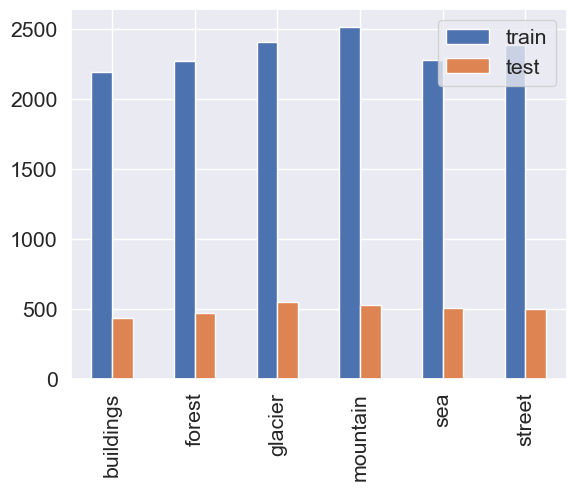

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts},
             index=class_names).plot.bar()
plt.show()

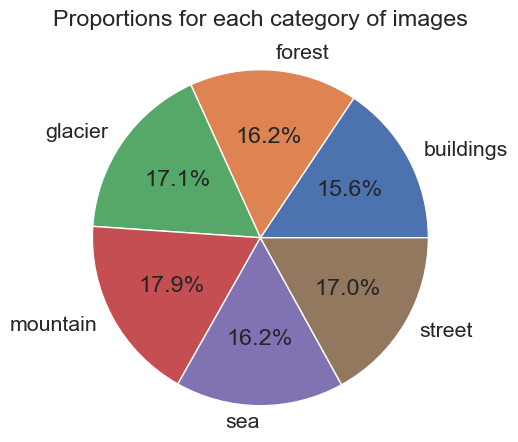

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0),
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportions for each category of images', y=1.05)
plt.show()

Scaling the data

In [9]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Function to output multiple images from a dataset

In [10]:
def display_examples(class_names, images, labels):
  fig = plt.figure(figsize=(10,10))
  fig.suptitle("Examples of dataset images", fontsize=16)
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
  plt.show()

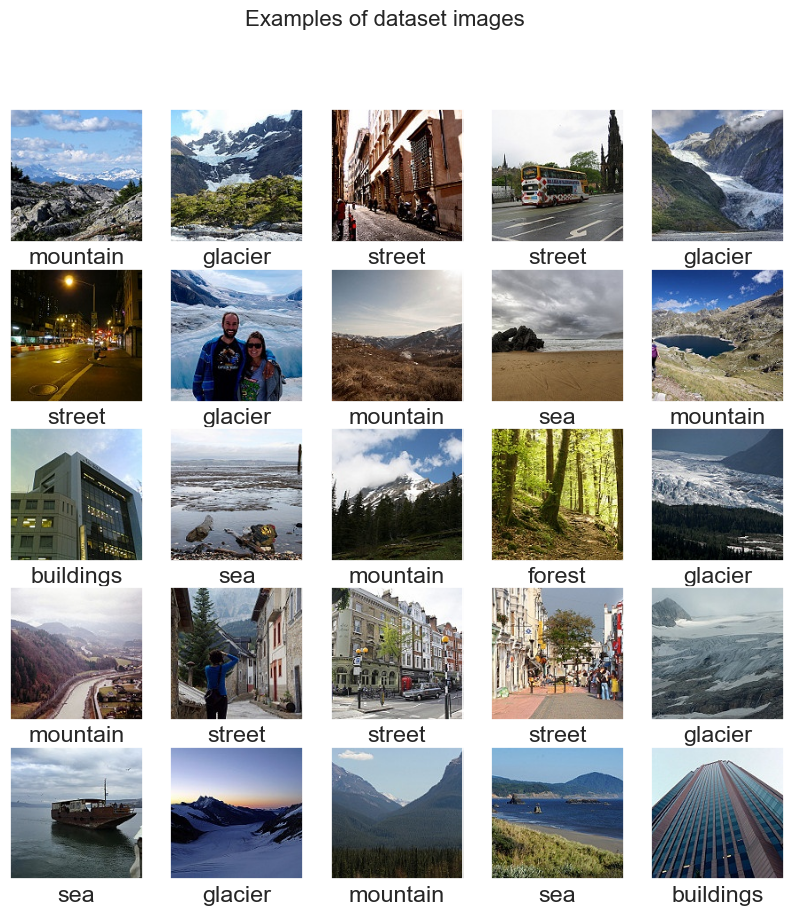

In [11]:
display_examples(class_names, train_images, train_labels)

# The first version of the VGG16 neural network

Using the VGG16 convolutional neural network for image classification

In [23]:
model = VGG16(weights='imagenet', include_top=False)

Predicting the probability of assignment to a particular class

In [24]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 150s 2s/step


Visualize the data using a two-dimensional representation (via PCA)

In [25]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [26]:
pca = decomposition.PCA(n_components=2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1]

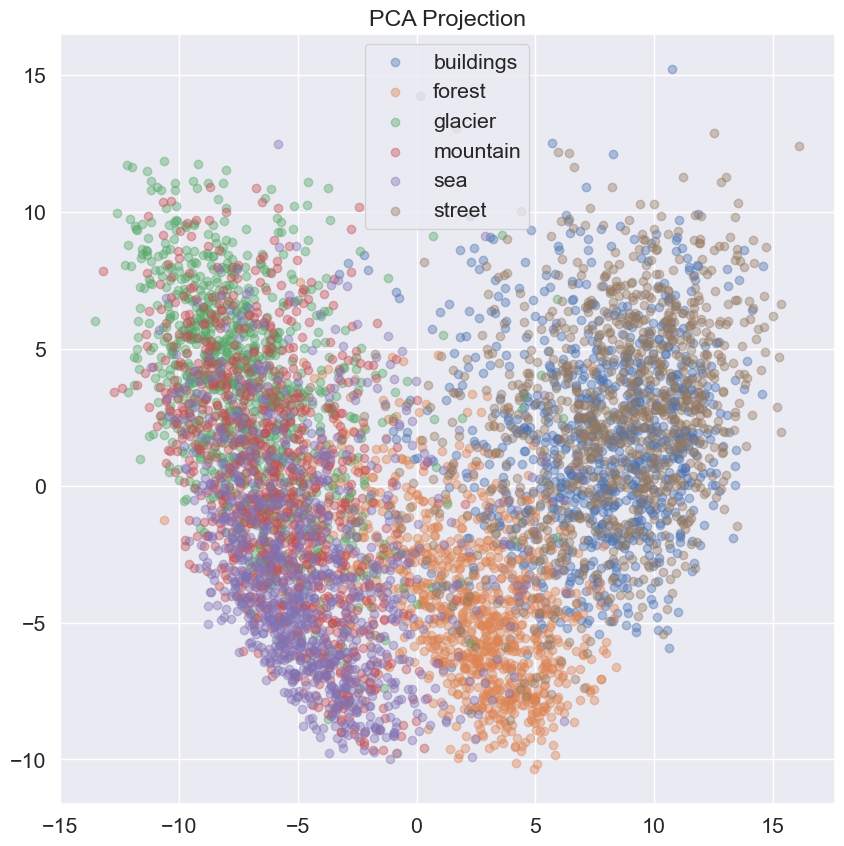

In [27]:
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label=class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

The class - the forest - stands out clearly. Streets and buildings overlap very much.There is also some overlap of glaciers, mountains, and seas.

Function for visualizing the lossfunction and metrics

In [12]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(13, 8))
    
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [29]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Build and train a neural network that will determine the class after VGG16

In [35]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(80, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split=0.2,
                     callbacks=[lr_rate])

Epoch 1/15
88/88 [==============================] - 2s 17ms/step - loss: 0.5578 - accuracy: 0.7966 - val_loss: 0.3665 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 2/15
88/88 [==============================] - 1s 16ms/step - loss: 0.3157 - accuracy: 0.8862 - val_loss: 0.3273 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 3/15
88/88 [==============================] - 1s 15ms/step - loss: 0.2374 - accuracy: 0.9171 - val_loss: 0.3332 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 4/15
88/88 [==============================] - 1s 16ms/step - loss: 0.1746 - accuracy: 0.9426 - val_loss: 0.3090 - val_accuracy: 0.8860 - lr: 2.5000e-04
Epoch 5/15
88/88 [==============================] - 1s 15ms/step - loss: 0.1567 - accuracy: 0.9514 - val_loss: 0.3103 - val_accuracy: 0.8874 - lr: 6.2500e-05
Epoch 6/15
88/88 [==============================] - 1s 15ms/step - loss: 0.1536 - accuracy: 0.9530 - val_loss: 0.3103 - val_accuracy: 0.8867 - lr: 6.2500e-05
Epoch 7/15
88/88 [==============================] - 1s 15ms/step

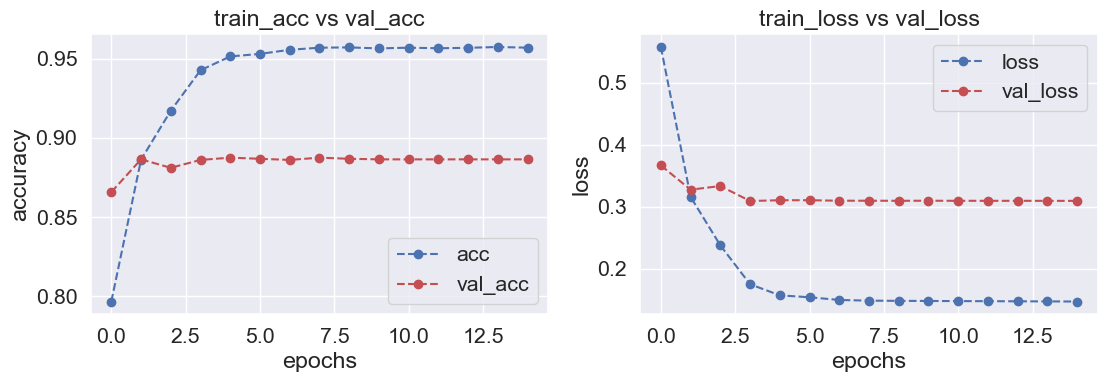

In [36]:
plot_accuracy_loss(history)

In [37]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.8867


accuracy on the test set < 0.9

# The second version of the VGG16 neural network

We will use VGG16 as the basis

Removing the last five layers of the neural network

In [11]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [12]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

94/94 [==============================] - 140s 1s/step


Let's complete this neural network, the last four layers of VGG16 are MLP, so let's change these layers

In [13]:
model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape=(9, 9, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(95, activation='relu')(x)
#x = Dense(20, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)

In [14]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Structure of the resulting model

In [15]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 64)         0   

In [16]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Neural network training

In [17]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split=0.2,
                        callbacks=[lr_rate])

Epoch 1/10
88/88 [==============================] - 220s 2s/step - loss: 0.7629 - accuracy: 0.6962 - val_loss: 0.4232 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 222s 3s/step - loss: 0.3588 - accuracy: 0.8741 - val_loss: 0.3048 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 223s 3s/step - loss: 0.2658 - accuracy: 0.9108 - val_loss: 0.2825 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 219s 2s/step - loss: 0.2221 - accuracy: 0.9233 - val_loss: 0.2774 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 220s 2s/step - loss: 0.1413 - accuracy: 0.9528 - val_loss: 0.2632 - val_accuracy: 0.9113 - lr: 2.5000e-04
Epoch 6/10
88/88 [==============================] - 223s 3s/step - loss: 0.1156 - accuracy: 0.9603 - val_loss: 0.2714 - val_accuracy: 0.9141 - lr: 2.5000e-04
Epoch 7/10
88/88 [==============================] - 228s 3s/step - l

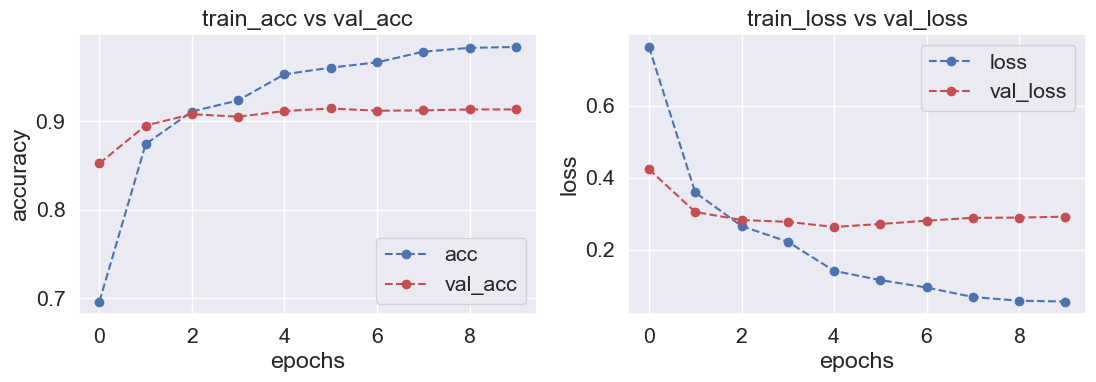

In [20]:
plot_accuracy_loss(history)

Final accuracy

In [21]:
predictions = new_model.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 12s 124ms/step
Accuracy: 0.9103333333333333


Точность > 0.9

# Inceptionv3 neural network

In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

Create an InceptionV3 model without a full-link layer

In [39]:
model_inceptionV3 = InceptionV3(weights='imagenet', include_top=False)

Extract features

In [40]:
train_features = model_inceptionV3.predict(train_images)
test_features = model_inceptionV3.predict(test_images)

94/94 [==============================] - 35s 371ms/step


In [41]:
_, x, y, z = train_features.shape

Build a small, fully-connected neural network that will make predictions based on the extracted features

In [42]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [43]:
model2_inceptionV3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_inceptionV3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_inceptionV3.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 10s 221ms/step - loss: 2.9666 - accuracy: 0.7592 - val_loss: 0.3682 - val_accuracy: 0.8874 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 9s 208ms/step - loss: 0.3357 - accuracy: 0.8928 - val_loss: 0.3349 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 9s 209ms/step - loss: 0.2570 - accuracy: 0.9080 - val_loss: 0.3625 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 9s 209ms/step - loss: 0.2009 - accuracy: 0.9270 - val_loss: 0.2925 - val_accuracy: 0.9067 - lr: 2.5000e-04
Epoch 5/10
44/44 [==============================] - 9s 209ms/step - loss: 0.1725 - accuracy: 0.9374 - val_loss: 0.2941 - val_accuracy: 0.9070 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 9s 209ms/step - loss: 0.1599 - accuracy: 0.9417 - val_loss: 0.2950 - val_accuracy: 0.9042 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 9s 20

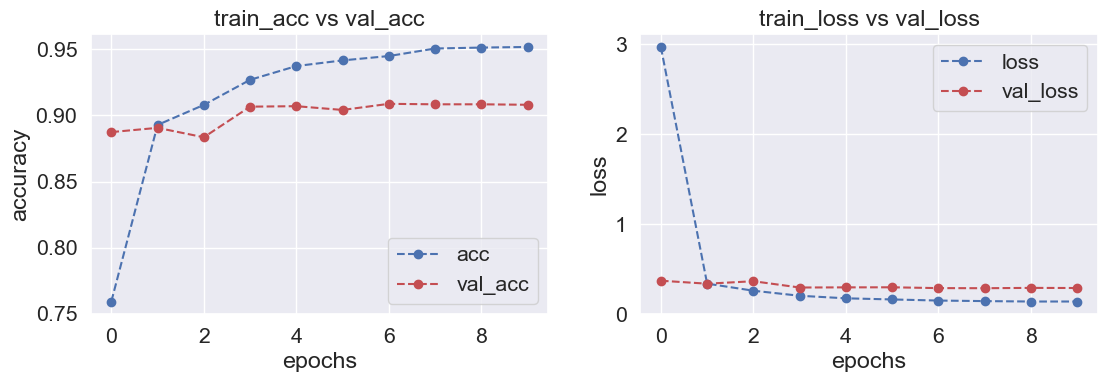

In [44]:
plot_accuracy_loss(history)

Accuracy

In [46]:
predictions = model2_inceptionV3.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 9ms/step
Accuracy: 0.905


# Xception Neural Network

In [47]:
from keras.applications import Xception

Creating the Xception model

In [48]:
model_Xception = Xception(include_top=False, weights='imagenet')

83683744/83683744 [==============================] - 10s 0us/step


Extracting features

In [49]:
train_features = model_Xception.predict(train_images)
test_features = model_Xception.predict(test_images)

94/94 [==============================] - 85s 859ms/step


In [50]:
_, x, y, z = train_features.shape

Build a small, fully-connected neural network that will make predictions based on the extracted features

In [51]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [60]:
model2_Xception = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_Xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_Xception.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 52s 1s/step - loss: 3.1919 - accuracy: 0.8102 - val_loss: 0.4604 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 49s 1s/step - loss: 0.2852 - accuracy: 0.9092 - val_loss: 0.2545 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 49s 1s/step - loss: 0.1813 - accuracy: 0.9368 - val_loss: 0.2757 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 49s 1s/step - loss: 0.1373 - accuracy: 0.9516 - val_loss: 0.2392 - val_accuracy: 0.9170 - lr: 2.5000e-04
Epoch 5/10
44/44 [==============================] - 50s 1s/step - loss: 0.1247 - accuracy: 0.9595 - val_loss: 0.2393 - val_accuracy: 0.9152 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 50s 1s/step - loss: 0.1094 - accuracy: 0.9658 - val_loss: 0.2414 - val_accuracy: 0.9152 - lr: 6.2500e-05
Epoch 7/10
44/44 [==============================] - 49s 1s/step - loss

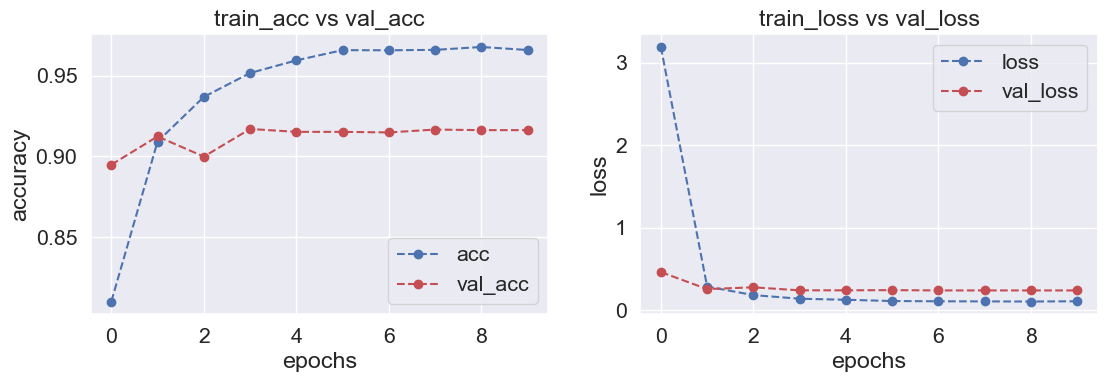

In [61]:
plot_accuracy_loss(history)

In [62]:
predictions = model2_Xception.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 3s 36ms/step
Accuracy: 0.912


# VGG 19 Neural Network

In [14]:
from keras.applications import VGG19

In [65]:
model_vgg19 = VGG19(include_top=False, weights='imagenet')

80134624/80134624 [==============================] - 9s 0us/step


In [66]:
train_features = model_vgg19.predict(train_images)
test_features = model_vgg19.predict(test_images)

94/94 [==============================] - 185s 2s/step


In [67]:
_, x, y, z = train_features.shape

In [68]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [74]:
model2_vgg19 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_vgg19.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_vgg19.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 2s 31ms/step - loss: 0.7748 - accuracy: 0.7257 - val_loss: 0.4385 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3733 - accuracy: 0.8686 - val_loss: 0.3909 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 1s 27ms/step - loss: 0.3119 - accuracy: 0.8891 - val_loss: 0.3824 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 1s 26ms/step - loss: 0.2735 - accuracy: 0.9041 - val_loss: 0.3522 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 1s 27ms/step - loss: 0.2360 - accuracy: 0.9217 - val_loss: 0.3480 - val_accuracy: 0.8682 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 1s 25ms/step - loss: 0.2064 - accuracy: 0.9336 - val_loss: 0.3370 - val_accuracy: 0.8685 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 1s 25ms/step - loss:

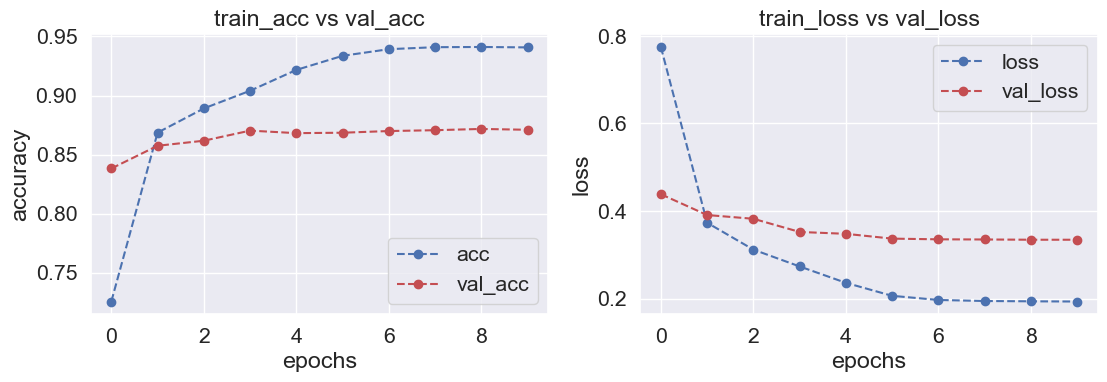

In [75]:
plot_accuracy_loss(history)

In [77]:
predictions = model2_vgg19.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 0s 2ms/step
Accuracy: 0.8723333333333333


# The second version of the VGG 19 neural network

In [17]:
model_vgg19 = VGG19(weights='imagenet', include_top=False)
model_vgg19 = Model(inputs=model_vgg19.inputs, outputs=model_vgg19.layers[-5].output)

In [18]:
train_features = model_vgg19.predict(train_images)
test_features = model_vgg19.predict(test_images)

94/94 [==============================] - 173s 2s/step


In [29]:
model2_vgg19 = VGG19(weights='imagenet', include_top=False)

input_shape = model2_vgg19.layers[-4].get_input_shape_at(0)
layer_input = Input(shape=(9, 9, 512))

x = layer_input
for layer in model2_vgg19.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dense(6, activation='softmax')(x)

new_model = Model(layer_input, x)

In [30]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 9, 9, 512)]       0         
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv4 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 64)         0   

In [32]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

In [33]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split=0.2,
                        callbacks=[lr_rate])

Epoch 1/10
88/88 [==============================] - 225s 3s/step - loss: 0.7477 - accuracy: 0.7165 - val_loss: 0.3876 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 2/10
88/88 [==============================] - 220s 3s/step - loss: 0.4186 - accuracy: 0.8602 - val_loss: 0.3408 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 3/10
88/88 [==============================] - 220s 3s/step - loss: 0.3592 - accuracy: 0.8846 - val_loss: 0.3523 - val_accuracy: 0.8885 - lr: 0.0010
Epoch 4/10
88/88 [==============================] - 221s 3s/step - loss: 0.2955 - accuracy: 0.9026 - val_loss: 0.3189 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 5/10
88/88 [==============================] - 220s 3s/step - loss: 0.2734 - accuracy: 0.9116 - val_loss: 0.3603 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 6/10
88/88 [==============================] - 220s 3s/step - loss: 0.1777 - accuracy: 0.9428 - val_loss: 0.2750 - val_accuracy: 0.9138 - lr: 2.5000e-04
Epoch 7/10
88/88 [==============================] - 220s 3s/step - loss:

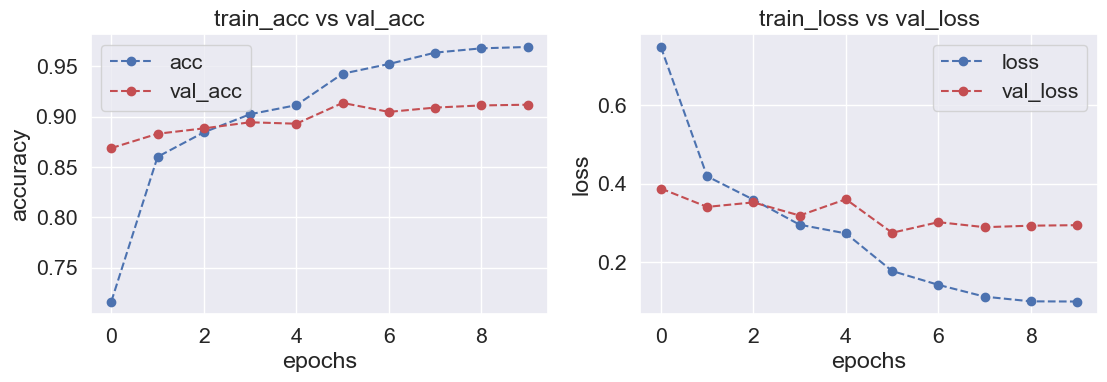

In [34]:
plot_accuracy_loss(history)

In [35]:
predictions = new_model.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 13s 141ms/step
Accuracy: 0.905


# Neural network ResNet50

In [36]:
from keras.applications import ResNet50V2

Creating the ResNet50V2 model

In [37]:
model_resNet50 = ResNet50V2(include_top=False, weights='imagenet')

94668760/94668760 [==============================] - 11s 0us/step


Extracting features

In [38]:
train_features = model_resNet50.predict(train_images)
test_features = model_resNet50.predict(test_images)

94/94 [==============================] - 87s 855ms/step


In [39]:
_, x, y, z = train_features.shape

In [40]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Training the model

In [57]:
model2_resNet50V2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dense(100, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet50V2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet50V2.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 7s 144ms/step - loss: 1.0961 - accuracy: 0.8315 - val_loss: 0.3196 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 6s 145ms/step - loss: 0.1664 - accuracy: 0.9434 - val_loss: 0.3130 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 6s 139ms/step - loss: 0.0763 - accuracy: 0.9771 - val_loss: 0.3099 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 6s 133ms/step - loss: 0.0381 - accuracy: 0.9914 - val_loss: 0.3157 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 6s 135ms/step - loss: 0.0190 - accuracy: 0.9971 - val_loss: 0.3118 - val_accuracy: 0.9120 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 6s 134ms/step - loss: 0.0156 - accuracy: 0.9980 - val_loss: 0.3164 - val_accuracy: 0.9120 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 6s 135ms/s

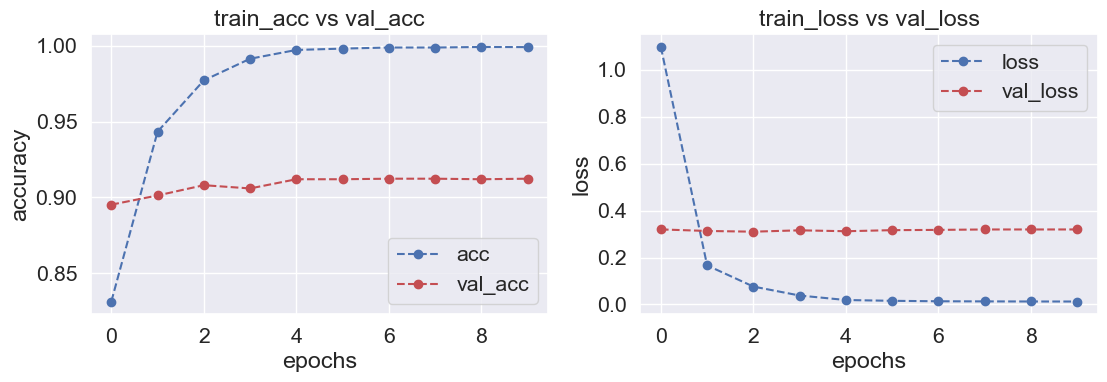

In [58]:
plot_accuracy_loss(history)

Accuracy

In [59]:
predictions = model2_resNet50V2.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 10ms/step
Accuracy: 0.9106666666666666


# ResNet101 neural network

In [60]:
from keras.applications import ResNet101V2

Building the ResNet101 model

In [61]:
model_resNet101 = ResNet101V2(include_top=False, weights='imagenet')

171317808/171317808 [==============================] - 20s 0us/step


Extracting features

In [62]:
train_features = model_resNet101.predict(train_images)
test_features = model_resNet101.predict(test_images)

94/94 [==============================] - 163s 2s/step


In [63]:
_, x, y, z = train_features.shape

In [64]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Training a neural network

In [77]:
model2_resNet101 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet101.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet101.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 50s 1s/step - loss: 3.5951 - accuracy: 0.8225 - val_loss: 0.5659 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 50s 1s/step - loss: 0.2565 - accuracy: 0.9262 - val_loss: 0.3086 - val_accuracy: 0.9092 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 49s 1s/step - loss: 0.1208 - accuracy: 0.9572 - val_loss: 0.2945 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 49s 1s/step - loss: 0.0704 - accuracy: 0.9743 - val_loss: 0.3437 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 49s 1s/step - loss: 0.0450 - accuracy: 0.9847 - val_loss: 0.3078 - val_accuracy: 0.9195 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 50s 1s/step - loss: 0.0344 - accuracy: 0.9887 - val_loss: 0.3049 - val_accuracy: 0.9184 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 48s 1s/step - loss: 0.

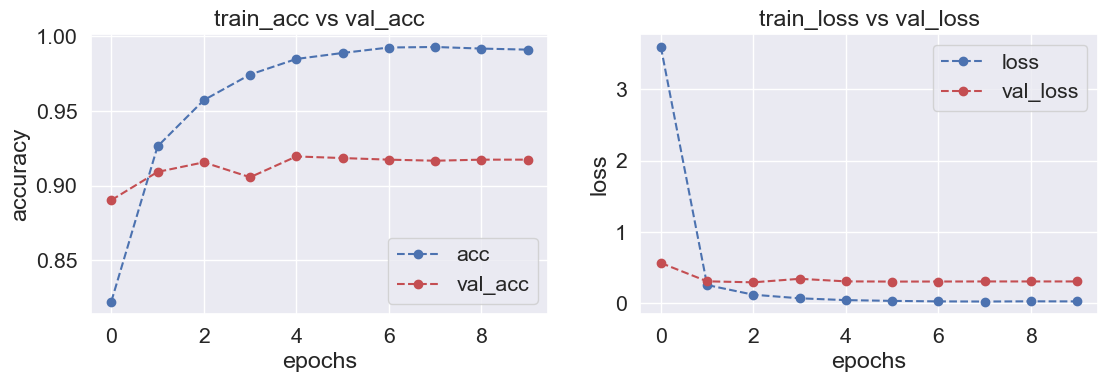

In [78]:
plot_accuracy_loss(history)

Accuracy

In [79]:
predictions = model2_resNet101.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 3s 36ms/step
Accuracy: 0.915


# Neural network ResNet152

In [13]:
from keras.applications import ResNet152V2

Creating the ResNet152 model

In [14]:
model_resNet152 = ResNet152V2(include_top=False, weights='imagenet')

Extracting features

In [15]:
train_features = model_resNet152.predict(train_images)
test_features = model_resNet152.predict(test_images)

94/94 [==============================] - 227s 2s/step


In [16]:
_, x, y, z = train_features.shape

In [17]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Training the model

In [41]:
model2_resNet152 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_resNet152.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_resNet152.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 17s 376ms/step - loss: 1.3118 - accuracy: 0.8303 - val_loss: 0.2937 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 15s 350ms/step - loss: 0.1885 - accuracy: 0.9336 - val_loss: 0.2608 - val_accuracy: 0.9116 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 15s 347ms/step - loss: 0.1048 - accuracy: 0.9626 - val_loss: 0.2831 - val_accuracy: 0.9084 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 15s 347ms/step - loss: 0.0605 - accuracy: 0.9810 - val_loss: 0.2719 - val_accuracy: 0.9131 - lr: 2.5000e-04
Epoch 5/10
44/44 [==============================] - 15s 346ms/step - loss: 0.0484 - accuracy: 0.9862 - val_loss: 0.2771 - val_accuracy: 0.9173 - lr: 2.5000e-04
Epoch 6/10
44/44 [==============================] - 15s 347ms/step - loss: 0.0429 - accuracy: 0.9873 - val_loss: 0.2845 - val_accuracy: 0.9092 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 

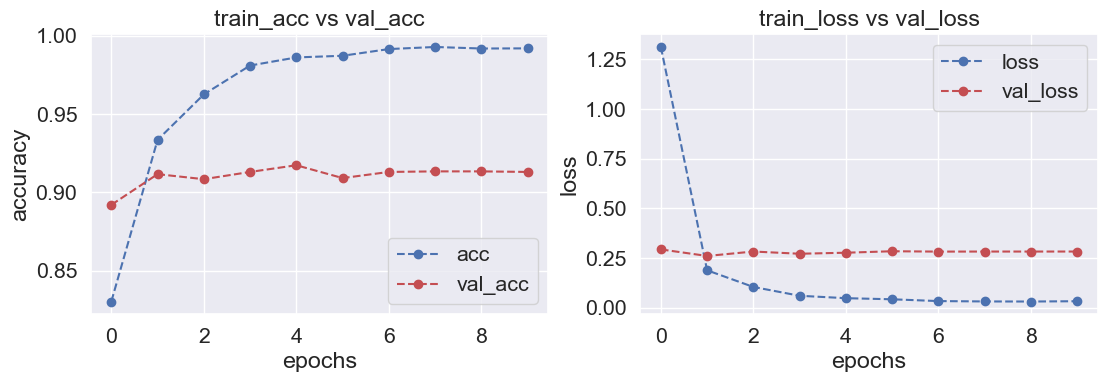

In [42]:
plot_accuracy_loss(history)

Accuracy

In [43]:
predictions = model2_resNet152.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 2s 16ms/step
Accuracy: 0.9116666666666666


# InceptionResNet neural network

In [46]:
from keras.applications import InceptionResNetV2

Creating a model

In [47]:
model_incptionResNet = InceptionResNetV2(include_top=False, weights='imagenet')

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of d19885ff4a710c122648d3b5c3b684e4 so we will re-download the data.
219055592/219055592 [==============================] - 25s 0us/step


Extracting features

In [48]:
train_features = model_incptionResNet.predict(train_images)
test_features = model_incptionResNet.predict(test_images)

94/94 [==============================] - 89s 947ms/step


In [52]:
_, x, y, z = train_features.shape

In [50]:
lr_rate = ReduceLROnPlateau(monitor='val_accuracy',
                            patience=1,
                            factor=0.25,
                            min_lr=0.000003)

Training a neural network to classify on extracted features

In [94]:
model2_incptionResNet = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(x, y, z)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2_incptionResNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history = model2_incptionResNet.fit(train_features, train_labels, batch_size=256,
                                 epochs=10, validation_split=0.2, callbacks=[lr_rate])

Epoch 1/10
44/44 [==============================] - 9s 182ms/step - loss: 1.9523 - accuracy: 0.7980 - val_loss: 0.2978 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 2/10
44/44 [==============================] - 8s 176ms/step - loss: 0.2905 - accuracy: 0.8961 - val_loss: 0.2861 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 3/10
44/44 [==============================] - 8s 173ms/step - loss: 0.2503 - accuracy: 0.9095 - val_loss: 0.2656 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 4/10
44/44 [==============================] - 8s 174ms/step - loss: 0.2139 - accuracy: 0.9200 - val_loss: 0.2763 - val_accuracy: 0.9095 - lr: 0.0010
Epoch 5/10
44/44 [==============================] - 8s 175ms/step - loss: 0.2034 - accuracy: 0.9224 - val_loss: 0.2721 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 6/10
44/44 [==============================] - 8s 173ms/step - loss: 0.1651 - accuracy: 0.9376 - val_loss: 0.2602 - val_accuracy: 0.9070 - lr: 2.5000e-04
Epoch 7/10
44/44 [==============================] - 8s 172ms/step 

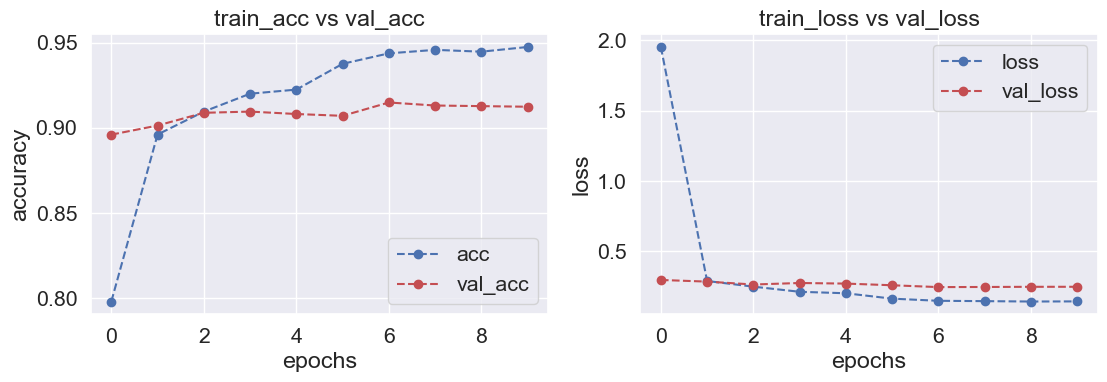

In [95]:
plot_accuracy_loss(history)

Accuracy

In [96]:
predictions = model2_incptionResNet.predict(test_features)
pred_labels = np.argmax(predictions, axis=1)
print("Accuracy: {}".format(accuracy_score(test_labels, pred_labels)))

94/94 [==============================] - 1s 7ms/step
Accuracy: 0.9156666666666666
